<a href="https://colab.research.google.com/github/anhle/tensorFlow2.x/blob/master/CNN_ca_vs_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build CNN to claffication Cat vs Dog

In this lesson you'll take that to the next level, recognizing real images of Cats and Dogs in order to classify an incoming image as one or the other. In particular the handwriting recognition made your life a little easier by having all the images be the same size and shape, and they were all monochrome color. Real-world images aren't like that -- they're in different shapes, aspect ratios etc, and they're usually in color!

So, as part of the task you need to process your data -- not least resizing it to be uniform in shape.

You'll follow these steps:

1. Explore the Example Data of Cats and Dogs
2. Build and Train a Neural Network to recognize the difference between the two
3. Evaluate the Training and Validation accuracy

## Explore the Example Data
Let's start by downloading our example data, a .zip of 25,000 JPG pictures of cats and dogs from the "[Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data)" dataset available on Kaggle, and extracting it locally in /tmp.

First, downloading Kaggle Datasets into Google Colab


In [0]:
!pip install -U -q kaggle
#Set the enviroment variables
import os
os.environ['KAGGLE_USERNAME'] = "anhle03"
os.environ['KAGGLE_KEY'] = "xxxx"
!mkdir -p /tmp/cats_and_dogs
os.chdir('/tmp/cats_and_dogs')
!kaggle competitions download -c dogs-vs-cats
!ls

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 79.9MB/s]
 95% 257M/271M [00:02<00:00, 103MB/s] 
100% 271M/271M [00:02<00:00, 98.6MB/s]
 97% 525M/543M [00:17<00:01, 18.4MB/s]
100% 543M/543M [00:17<00:00, 33.0MB/s]
sampleSubmission.csv  test1.zip  train.zip


Note: Click "Rule" menu and accepted

The following python code will use the OS library to use Operating System libraries, giving you access to the file system, and the zipfile library allowing you to unzip the data.

Note: Skip unzip the "sampleSubmission.csv"

In [0]:
import zipfile
for file in os.listdir():
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

Let's find out the total number of cat and dog images in the train and validation directories:

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

base_dir = "/tmp/cats_and_dogs/train"
filenames = os.listdir(base_dir)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df['category'] = df['category'].apply(str)

In [0]:
df.head()

,filename,category
0,cat.9437.jpg,0
1,cat.10925.jpg,0
2,dog.3025.jpg,1
3,dog.11277.jpg,1
4,cat.7916.jpg,0


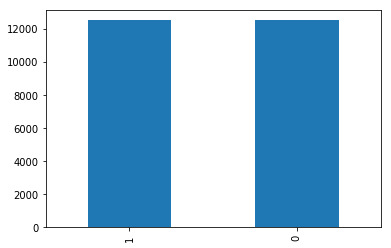

In [0]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

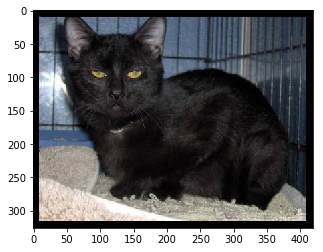

In [0]:
import random
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

sample = random.choice(filenames)
img = mpimg.imread(os.path.join(base_dir, sample) )
plt.imshow(img)

## Building a Small Model from Scratch to Get to ~72% Accuracy
In the previous section you saw that the images were in a variety of shapes and sizes. In order to train a neural network to handle them you'll need them to be in a uniform size. We've chosen 150x150 for this, and you'll see the code that preprocesses the images to that shape shortly.

Next we will define a Sequential layer as before, adding some convolutional layers first. 

* Note the input shape parameter this time. In the earlier example it was 28x28x1, because the image was 28x28 in greyscale (8 bits, 1 byte for color depth). This time it is 150x150 for the size and 3 (24 bits, 3 bytes) for the color depth.

* We then add a couple of convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

* Finally we add the densely connected layers.

Note that because we are facing a two-class classification problem, i.e. a binary classification problem, we will end our network with a sigmoid activation, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

* We will use the rmsprop optimizer with a learning rate of 0.001. During training, we will want to monitor classification accuracy.

NOTE: In this case, using the RMSprop optimization algorithm is preferable to stochastic gradient descent (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as Adam and Adagrad, also automatically adapt the learning rate during training, and would work equally well here.)

![alt text](https://i.imgur.com/ebkMGGu.jpg)

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Import TensorFlow
!pip install -q tensorflow==2.0.0-alpha0

import tensorflow as tf
print(tf.__version__)


2.0.0-alpha0


In [0]:
from   tensorflow import keras
from tensorflow.keras import Sequential, Model, datasets, layers,optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import RMSprop

IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color

model = Sequential()

# Note the input shape is the desired size of the image 150x150 with 3 bytes color
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten the results to feed into a DNN
model.add(Flatten())
# 512 neuron hidden layer
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['acc'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_v2_8 (Ba (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_v2_9 (Ba (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)       

## Callbacks

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

# Data Preprocessing
Let's set up data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs: fit_generator, evaluate_generator, and predict_generator.

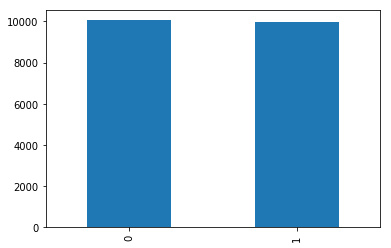

In [0]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()

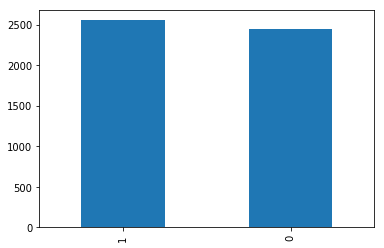

In [0]:
validate_df['category'].value_counts().plot.bar()

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=20
IMAGE_SIZE=(150, 150)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,# All images will be rescaled by 1./255.
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_dir, 
    x_col='filename',
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 20000 images belonging to 2 classes.


Validation Generator

In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_dir, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 5000 images belonging to 2 classes.


## Fit Model

In [0]:
history = model.fit_generator(
    train_generator, 
    epochs=20,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

model.save_weights("model.h5")

Epoch 1/20
1000/1000 [==============================] - 1692s 2s/step - loss: 0.6270 - acc: 0.6750 - val_loss: 0.6814 - val_acc: 0.6642
Epoch 2/20
1000/1000 [==============================] - 1685s 2s/step - loss: 0.5319 - acc: 0.7317 - val_loss: 0.5226 - val_acc: 0.7492
Epoch 3/20
  14/1000 [..............................] - ETA: 27:18 - loss: 0.4871 - acc: 0.7679

## Virtualize Training
Let's plot the training/validation accuracy and loss as collected during training:

In [1]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

NameError: ignored

In [0]:
test_filenames = os.listdir("/tmp/cats_and_dogs/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## Create Testing Generator

In [0]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/tmp/cats_and_dogs/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

## Predict

In [0]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [0]:
threshold = 0.5
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)

Virtaulize Result

In [0]:
test_df['category'].value_counts().plot.bar()

See predicted result with images

In [0]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    probability = row['probability']
    img = load_img("/tmp/cats_and_dogs/test1"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' '(' + "{}".format(round(probability, 2)) + ')')
plt.tight_layout()
plt.show()